In [21]:
import numpy as np_ # Original numpy 
import scipy as sp

import random

# Plot
from IPython.display import display, Latex
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator

# PennyLane
import pennylane as qml
from pennylane import numpy as np

# qnode device
dev = qml.device('default.mixed', wires = 1)

# Hamiltonian setup 
coeffs = [-0.5]
obs = [qml.PauliZ(0)]

hamiltonian = qml.Hamiltonian(coeffs, obs)  # Define Hamiltonian

In [22]:
# Global paras 
Tau_global = 5e-2   # Dephase tau
# Tau_global = 1e-100   # Dephase tau
Paras_global, Phi_global, Gamma_ps  = np.zeros(2), 0, 0

def Dephase_factor(tau):
    """ Take tau and return gamma based on the following relation."""

    Calculate_Gamma = 1 - np.exp(-2 * tau)
    
    return Calculate_Gamma    # Return gamma

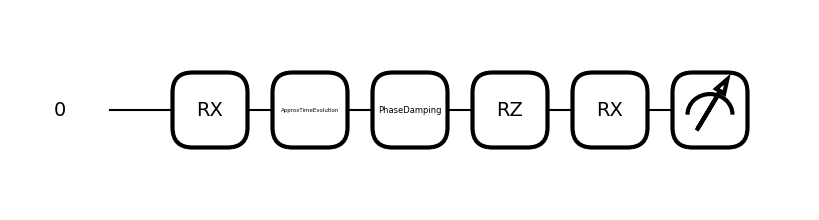

In [23]:
@qml.qnode(dev)
def circuit(paras):
    global Phi_global, Tau_global
    phi = Phi_global
    
    # Set dephase factor 
    gamma_dephase_in = Dephase_factor(Tau_global)  

    theta_x, phi_z = paras[0], paras[1]

    qml.RX(np.pi/2, wires = 0)
    # qml.Hadamard(wires=0)

    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)

    qml.RZ(phi_z, wires = 0)  # phi_z
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)


@qml.qnode(dev)
def Post_selection_Dephase(phi):
    """ Take qnode from circuit_1 and calculate decoherence using kraus operator.
    
    Args:
        phi (float): Phi for Time-approximation. Pass by global variables:'Phi_global'

    Returns:
        qml.density_matrix: Density matrix of full qnode
    """
    
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires = 0)
    
    # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    
    Numerator = K @ density_matrix @ K.conj().T
    Denominator = np.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = 0)
    
    return qml.density_matrix(wires = 0) 

paras_plot = 1,1
fig, ax = qml.draw_mpl(circuit)(paras_plot)

In [24]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi[0])
    
    return -CFI

In [25]:
# # == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
# def BFGS(Sweep_Data, paras, gamma_ps_select, Iterations):
#     """ Perform maximum optimization using the L-BFGS-B algorithm.

#     Args:
#         Sweep_Data (numpy_array): Range of data sweeps.
#         paras (numpy_array): Array of 3 parameters for the qnode.
#         gamma_ps_select (int): The Gamma value for post-selection.
#         Iterations (int): Number of iterations for the optimization.

#     Returns:
#         Numpy array: 3-Dimension Data array
#     """
    
#     # Create Data array
#     PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
#     Data = np_.zeros((Iterations + 1, len(PHI), len(paras) + 2)) 
    
#     Data[:, :, 0] = PHI.squeeze() # Append PHI in to 0th col
    
#     # INDEX CONSTANT
#     CFI_INDEX, PARAS_INDEX, BEFORE_OPT_LAYER_INDEX = 1, 2, 0
    
#     # Set global variables
#     global Gamma_ps, Phi_global, Paras_global
#     Gamma_ps = gamma_ps_select 
    
#     # Declare Paras temp 
#     Paras_Temporary = 0
    
#     # Before optimization; CFI data
#     for Phi_Index in range(len(PHI)):
#         Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][CFI_INDEX] = -Cost_function(paras)
        
#         for Paras_Index_Array in range(len(paras)):
#             Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][PARAS_INDEX + Paras_Index_Array] = paras[Paras_Index_Array]
        
        
#     # Optimize begin
#     for Layer_Index in range(1, Iterations + 1):
#         for Phi_Index in range(len(PHI)):
#             # Load previous paras
#             Paras_Temporary = paras if Layer_Index == 1 else Data[Layer_Index][Phi_Index][PARAS_INDEX:]
            
#             # Set Phi(Currently sweeping)
#             Phi_global = Data[Layer_Index][Phi_Index][0]
            
#             # Constraints(gamma = 0.99..) 
#             tau_upper = 18
#             Constraints = [(-float('inf'), float('inf'))] * 2 
            
#             # Push paras to global var
#             Paras_global = Paras_Temporary
#             Result_BFGS = sp.optimize.minimize(Cost_function, Paras_Temporary, method = 'L-BFGS-B', bounds = Constraints)
#             Data[Layer_Index][Phi_Index][CFI_INDEX] = -Result_BFGS.fun
            
#             # Store data in array
#             for Paras_Index_Array in range(len(Paras_Temporary)):
#                 Data[Layer_Index][Phi_Index][PARAS_INDEX + Paras_Index_Array] = Result_BFGS.x[Paras_Index_Array]
            
#     return Data

In [26]:
# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def BFGS(Sweep_Data, paras, gamma_ps_select, Iterations):
    """ 
    Perform maximum optimization using the L-BFGS-B algorithm.

    Args:
        sweep_data (tuple): (start, end, step) values for the sweep.
        initial_parameters (numpy_array): Array of parameters for the qnode.
        gamma_ps_select (int): The Gamma value for post-selection.
        iterations (int): Number of iterations for the optimization.

    Returns:
        Numpy array: 3-Dimension Data array containing phi, CFI, and optimized parameters.
    """
    
    # INDEX CONSTANT
    CFI_INDEX = 1
    PARAS_INDEX = 2
    
    # Create Data array
    PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
    Data = np_.zeros((Iterations + 1, len(PHI), len(paras) + 2)) 
    Data[:, :, 0] = PHI.squeeze() # Append PHI in to 0th col
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps_select 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    # Store initial CFI data and parameters
    for idx, phi in enumerate(PHI):
        Data[0][idx][CFI_INDEX] = -Cost_function(paras)
        Data[0][idx][PARAS_INDEX:] = paras
        
    # Optimize begin
    for iteration in range(1, Iterations + 1):
        for phi_idx, phi_current in enumerate(PHI):
            # Load previous paras
            Paras_Temporary = paras if iteration == 1 else Data[iteration][phi_idx][PARAS_INDEX:]
                
            # Set Phi(Currently sweeping)
            Phi_global = phi_current[0]
            
            # Set constraints
            N = int(phi_current[0] / np.pi) + 1            
            if ((phi_current[0] < 1.4 * N) or (phi_current[0] > 1.7 * N)):
                Constraints = [(0, np.pi)] * 2
            else:
                # Constraints = [(-float('inf'), float('inf'))] * 2  
                Constraints = [(-np.pi/2, (3*np.pi)/2)] * 2 

            # Push paras to global var
            Paras_global = Paras_Temporary
            Result_BFGS = sp.optimize.minimize(
                Cost_function, 
                Paras_Temporary, 
                method = 'L-BFGS-B', 
                bounds = Constraints,
                # options={'maxiter': 16000*10}
                )
            
            Data[iteration][phi_idx][CFI_INDEX] = -Result_BFGS.fun
            Data[iteration][phi_idx][PARAS_INDEX:] = Result_BFGS.x
            
    return Data

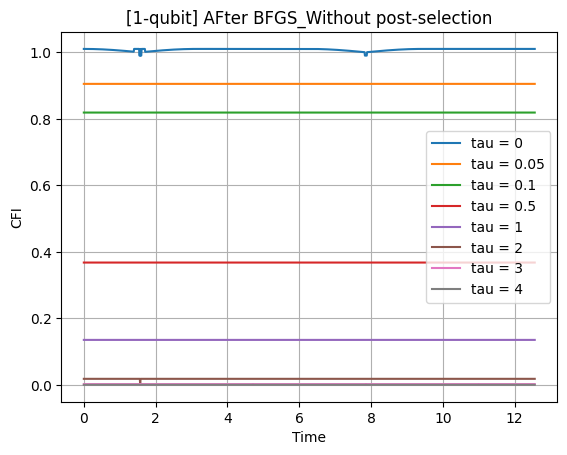

In [27]:
tau_plot = 0, 5e-2, 1e-1, 5e-1, 1, 2, 3, 4
Sweep_data = np_.array([0, np.pi * 4 , 1e-2])

Sweep_data_arange = np_.arange(Sweep_data[0], Sweep_data[1], Sweep_data[2])

Para_store = np.zeros((len(tau_plot), len(Sweep_data_arange), 2))

for i in range(len(tau_plot)):
    Tau_global = tau_plot[i]
    
    Paras_init = np.zeros(2)
    Paras_init[:2] = np.pi/2

    Gamma_ps_preset = 1e-2
    Set_Iterations = 1
    
    Optimized_Result = BFGS(
        Sweep_data, 
        Paras_init, 
        Gamma_ps_preset, 
        Set_Iterations
        )
    
    Para_store[i][:, 0] = Optimized_Result[1][:,2]
    Para_store[i][:, 1] = Optimized_Result[1][:,3]
    
    # plt.plot(Sweep_data_arange, Optimized_Result[0][:, 1], label = f'Before_tau = {tau_plot[i]}')
    plt.plot(Sweep_data_arange, Optimized_Result[1][:, 1], label = f'$\\tau$ = {tau_plot[i]}')
    
plt.title(f'[1-qubit] AFter BFGS_Without post-selection')    
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()

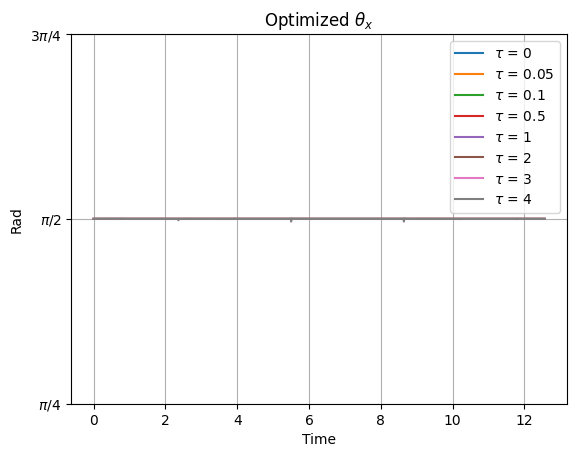

In [28]:
for i in range(0, len(tau_plot)):
    plt.plot(Sweep_data_arange, Para_store[i][:, 0], label = f'$\\tau$ = {tau_plot[i]}')

# Set the yticks to be at π/4, π/2, and 3π/4
plt.yticks([np.pi/4, np.pi/2, 3*np.pi/4], ['$\pi/4$', '$\pi/2$', '$3\pi/4$'])

plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

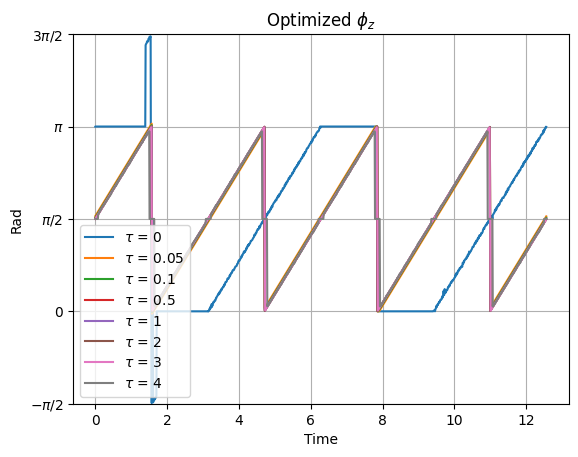

In [29]:
for i in range(0, len(tau_plot)):
    # if i != 4:
        plt.plot(Sweep_data_arange, Para_store[i][:, 1], label = f'$\\tau$ = {tau_plot[i]}')

# Set the yticks to be at -2π, -π, 0, π, and 2π
# plt.yticks([-np.pi, 0, np.pi, 2*np.pi], ['$-\pi$', '0', '$\pi$', '$2\pi$'])
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.ylim(-1*np.pi/2, 3*np.pi/2)

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

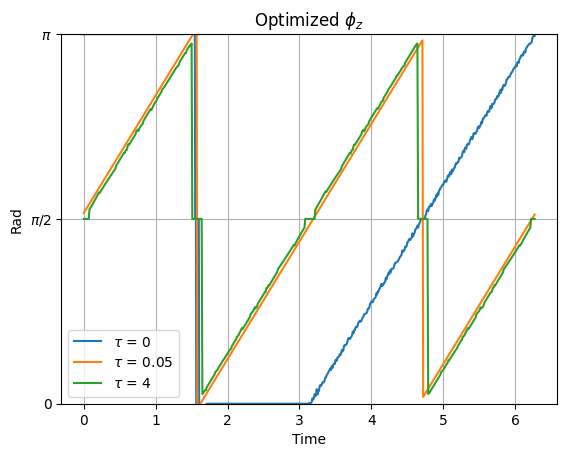

In [30]:
slice = int(len(Sweep_data_arange) / 2)

tau_control = 5
plt.plot(Sweep_data_arange[:slice], Para_store[0][:slice, 1], label = f'$\\tau$ = {tau_plot[0]}')
plt.plot(Sweep_data_arange[:slice], Para_store[1][:slice, 1], label = f'$\\tau$ = {tau_plot[1]}')
plt.plot(Sweep_data_arange[:slice], Para_store[7][:slice, 1], label = f'$\\tau$ = {tau_plot[7]}')

# Set the yticks to be at -2π, -π, 0, π, and 2π
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.ylim(0, 1*np.pi)

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

In [31]:
np.pi*1e-2

0.031415926535897934

In [32]:
Para_store[0][:,0]

tensor([1.57079634, 1.57079732, 1.57079633, ..., 1.57079517, 1.57079632,
        1.57079634], requires_grad=True)

In [33]:
Para_store[0][:,1]

tensor([3.13930885, 3.14159244, 3.14159265, ..., 3.12718769, 3.12096294,
        3.13471405], requires_grad=True)

In [34]:
Optimized_Result

array([[[0.00000000e+00, 3.35440941e-04, 1.57079633e+00, 1.57079633e+00],
        [1.00000000e-02, 3.35440941e-04, 1.57079633e+00, 1.57079633e+00],
        [2.00000000e-02, 3.35440941e-04, 1.57079633e+00, 1.57079633e+00],
        ...,
        [1.25400000e+01, 3.35440941e-04, 1.57079633e+00, 1.57079633e+00],
        [1.25500000e+01, 3.35440941e-04, 1.57079633e+00, 1.57079633e+00],
        [1.25600000e+01, 3.35440941e-04, 1.57079633e+00, 1.57079633e+00]],

       [[0.00000000e+00, 3.35454157e-04, 1.57079633e+00, 1.57079633e+00],
        [1.00000000e-02, 3.35420006e-04, 1.57079633e+00, 1.57079633e+00],
        [2.00000000e-02, 3.35318985e-04, 1.57079633e+00, 1.57080980e+00],
        ...,
        [1.25400000e+01, 3.35222948e-04, 1.57079633e+00, 1.57077871e+00],
        [1.25500000e+01, 3.35365424e-04, 1.57079633e+00, 1.57078541e+00],
        [1.25600000e+01, 3.35440941e-04, 1.57079633e+00, 1.57079633e+00]]])